In [2]:
import pandas as pd
import math
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, ColorJitter, RandomHorizontalFlip 

# Race tagging of Affectnet set

We modify the training and validation set in a few ways.
1. We tag each filepath with the race labels obtained from a fairface classifier (karkainnen cite)
2. We remove images that have multiple race labels (these arise from fairface detecting multiple faces in the image)
3. We remove images that have no race labels 
4. We remove grayscale images (since the fairface classifier is trained on color images, the validity of the tag is suspect for these grayscale images and could negatively impact downstream training)

These removals result in around 10% loss of data points, but we still have approximately 259k images to use

In [3]:
val_filepath = pd.read_csv('val_fairface.csv')
val_race_labels = pd.read_csv('val_set_race_tags.csv')

In [51]:
val_race_labels

,face_name_align,race,race4,gender,age,race_scores_fair,race_scores_fair_4,gender_scores_fair,age_scores_fair
0,detected_faces/4568_face0.jpg,Middle Eastern,White,Male,50-59,[2.1768291e-01 1.4239328e-04 7.1944304e-02 5.4...,[9.8546553e-01 2.7187154e-04 2.5925806e-03 1.1...,[0.9977683 0.00223171],[1.03524035e-04 6.51737500e-05 5.14067360e-04 ...
1,detected_faces/4478_face0.jpg,White,White,Female,20-29,[8.4236777e-01 2.4383063e-03 3.8513407e-02 2.7...,[0.9737646 0.00994458 0.00371436 0.01257646],[1.7768645e-04 9.9982232e-01],[9.0873023e-08 7.9405319e-05 4.4749342e-02 8.2...
2,detected_faces/3680_face0.jpg,Middle Eastern,White,Male,30-39,[9.6322842e-02 1.0394508e-04 8.7318001e-03 4.9...,[9.8704094e-01 8.1902806e-04 2.1604712e-03 9.9...,[9.9950171e-01 4.9830845e-04],[4.8120575e-07 3.4811026e-06 9.5351937e-04 8.0...
3,detected_faces/3517_face0.jpg,Latino_Hispanic,White,Female,20-29,[4.0056580e-01 3.0805604e-04 5.6589925e-01 4.4...,[0.9123944 0.00995923 0.05633626 0.02131009],[3.3785572e-04 9.9966210e-01],[9.3651465e-08 3.9603107e-04 2.0330741e-01 7.0...
4,detected_faces/3052_face0.jpg,White,White,Female,20-29,[9.9764246e-01 5.8052287e-06 4.1569347e-04 3.5...,[9.9938327e-01 1.5375306e-04 4.3561461e-04 2.7...,[0.00827326 0.99172676],[5.7399154e-07 1.2058897e-04 3.5707895e-02 6.9...
...,...,...,...,...,...,...,...,...,...
3989,detected_faces/2815_face0.jpg,White,White,Male,0-2,[9.4298667e-01 6.7099900e-05 3.6430648e-03 1.0...,[9.9915570e-01 1.1401189e-04 4.6327180e-04 2.6...,[0.6978695 0.30213052],[9.9763316e-01 2.2303043e-03 7.3485994e-06 2.0...
3990,detected_faces/5319_face0.jpg,White,White,Male,20-29,[5.7785457e-01 2.3699529e-04 9.9663585e-03 4.8...,[9.9765849e-01 2.1385393e-04 1.5424088e-03 5.8...,[0.99833655 0.00166348],[1.11776750e-07 1.17308991e-04 1.09551385e-01 ...
3991,detected_faces/4667_face0.jpg,White,White,Male,0-2,[9.4282937e-01 9.4709168e-05 1.0409109e-02 2.1...,[9.9657118e-01 4.6331726e-04 1.2851665e-03 1.6...,[0.97190595 0.02809404],[8.03962231e-01 1.67595521e-01 4.07164171e-03 ...
3992,detected_faces/2865_face0.jpg,White,White,Male,30-39,[9.8754233e-01 4.7955664e-06 7.0674147e-04 7.3...,[9.9548030e-01 2.9274950e-06 4.4952673e-03 2.1...,[9.9960011e-01 3.9988966e-04],[5.9655504e-06 6.4635744e-05 6.6195382e-03 7.8...


In [52]:
val_filepath['id'] = val_filepath['img_path'].str.extract(r'.*/(\d{1}|\d{2}|\d{3}|\d{4}|\d{5})\..*')
val_race_labels['id']=val_race_labels['face_name_align'].str.extract(r'.*/(\d{1}|\d{2}|\d{3}|\d{4}|\d{5})_.*')
val_race_labels = val_race_labels.dropna()

In [53]:
# joining
val_filepath = val_filepath.join(val_race_labels.groupby('id').agg({'race': lambda x: list(x)}), on = "id", how = "left")
val_filepath = val_filepath.join(val_race_labels.groupby('id').agg({'race4': lambda x: list(x)}), on = "id", how = "left")
val_filepath = val_filepath.join(val_race_labels.groupby('id').agg({'gender': lambda x: list(x)}), on = "id", how = "left")

In [54]:
# num obs we lose
val_filepath

,img_path,id,race,race4,gender
0,../val_set/images/5486.jpg,5486,[White],[White],[Male]
1,../val_set/images/3632.jpg,3632,[White],[White],[Male]
2,../val_set/images/3167.jpg,3167,[Black],[Black],[Female]
3,../val_set/images/5183.jpg,5183,[White],[White],[Male]
4,../val_set/images/4837.jpg,4837,[White],[White],[Female]
...,...,...,...,...,...
3994,../val_set/images/2015.jpg,2015,[White],[White],[Female]
3995,../val_set/images/1398.jpg,1398,[White],[White],[Female]
3996,../val_set/images/1530.jpg,1530,[Middle Eastern],[White],[Female]
3997,../val_set/images/2108.jpg,2108,[White],[White],[Male]


In [55]:
# check to see if mult faces detected in a single image
multi_label_ids = []
for i, row in val_filepath.iterrows():
    if type(row['race']) is list:
        if len(row['race']) > 1:
            multi_label_ids.append(row['id'])
    else:
        continue
np.where(val_filepath['id'].isin(multi_label_ids))[0]

array([ 725, 2603, 3024], dtype=int64)

In [65]:
val_filepath.loc[np.where(val_filepath['id'].isin(multi_label_ids))[0], 'race'] = None
val_filepath.loc[np.where(val_filepath['id'].isin(multi_label_ids))[0], 'race4'] = None
val_filepath.loc[np.where(val_filepath['id'].isin(multi_label_ids))[0], 'gender'] = None

val_filepath

,img_path,id,race,race4,gender
0,../val_set/images/5486.jpg,5486,[White],[White],[Male]
1,../val_set/images/3632.jpg,3632,[White],[White],[Male]
2,../val_set/images/3167.jpg,3167,[Black],[Black],[Female]
3,../val_set/images/5183.jpg,5183,[White],[White],[Male]
4,../val_set/images/4837.jpg,4837,[White],[White],[Female]
...,...,...,...,...,...
3994,../val_set/images/2015.jpg,2015,[White],[White],[Female]
3995,../val_set/images/1398.jpg,1398,[White],[White],[Female]
3996,../val_set/images/1530.jpg,1530,[Middle Eastern],[White],[Female]
3997,../val_set/images/2108.jpg,2108,[White],[White],[Male]


In [63]:
val_filepath[val_filepath['id'] == '2455']

,img_path,id,race,race4,gender
725,../val_set/images/2455.jpg,2455,Mult,Mult,Mult


In [66]:
val_filepath.race.value_counts(dropna=False)

[White]              2757
[Middle Eastern]      316
[Latino_Hispanic]     288
[Black]               281
[East Asian]          204
[Indian]               79
[Southeast Asian]      58
NaN                    13
None                    3
Name: race, dtype: int64

In [67]:
val_filepath = val_filepath.dropna()
val_filepath['race'] = val_filepath['race'].str[0]
val_filepath['race4'] = val_filepath['race4'].str[0]
val_filepath['gender'] = val_filepath['gender'].str[0]

<ipython-input-67-59a174198863>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_filepath['race'] = val_filepath['race'].str[0]
<ipython-input-67-59a174198863>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_filepath['race4'] = val_filepath['race4'].str[0]
<ipython-input-67-59a174198863>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [68]:
val_filepath

,img_path,id,race,race4,gender
0,../val_set/images/5486.jpg,5486,White,White,Male
1,../val_set/images/3632.jpg,3632,White,White,Male
2,../val_set/images/3167.jpg,3167,Black,Black,Female
3,../val_set/images/5183.jpg,5183,White,White,Male
4,../val_set/images/4837.jpg,4837,White,White,Female
...,...,...,...,...,...
3994,../val_set/images/2015.jpg,2015,White,White,Female
3995,../val_set/images/1398.jpg,1398,White,White,Female
3996,../val_set/images/1530.jpg,1530,Middle Eastern,White,Female
3997,../val_set/images/2108.jpg,2108,White,White,Male


In [69]:
val_filepath.to_csv('affectnet_val_filepath_full.csv')

In [74]:
li = []
all_files = glob.glob(os.path.join("./" , "train_fairface_race_pred*.csv"))
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame.shape, frame.drop_duplicates().shape

((286988, 9), (286988, 9))

In [75]:
train_filepath = pd.read_csv('train_fairface.csv')
train_filepath

,img_path
0,../train_set/images/275643.jpg
1,../train_set/images/155796.jpg
2,../train_set/images/1262.jpg
3,../train_set/images/92652.jpg
4,../train_set/images/301876.jpg
...,...
287646,../train_set/images/256119.jpg
287647,../train_set/images/208039.jpg
287648,../train_set/images/370243.jpg
287649,../train_set/images/95746.jpg


In [76]:
train_filepath['id'] = train_filepath['img_path'].str.extract(r'.*/(\d{1}|\d{2}|\d{3}|\d{4}|\d{5}|\d{6})\..*')
frame['id']=frame['face_name_align'].str.extract(r'.*/(\d{1}|\d{2}|\d{3}|\d{4}|\d{5}|\d{6})_.*')
frame = frame.dropna()

# joining
train_filepath = train_filepath.join(frame.groupby('id').agg({'race': lambda x: list(x)}), on = "id", how = "left")
train_filepath = train_filepath.join(frame.groupby('id').agg({'race4': lambda x: list(x)}), on = "id", how = "left")
train_filepath = train_filepath.join(frame.groupby('id').agg({'gender': lambda x: list(x)}), on = "id", how = "left")

# check to see if mult faces detected in a single image
multi_label_ids = []
for i, row in train_filepath.iterrows():
    if type(row['race']) is list:
        if len(row['race']) > 1:
            multi_label_ids.append(row['id'])
    else:
        continue
np.where(train_filepath['id'].isin(multi_label_ids))[0]

array([   404,    535,    542,   1358,   2101,   6172,   7878,   8729,
        10650,  12813,  13009,  13190,  14570,  14683,  15146,  15367,
        15393,  18094,  18936,  20038,  20062,  20886,  22584,  22669,
        24736,  25619,  26328,  27639,  27752,  28153,  29888,  30055,
        30524,  31725,  32338,  33081,  34514,  34522,  35831,  35980,
        36154,  37215,  38108,  38372,  38456,  39192,  40470,  41564,
        42000,  42170,  42281,  42882,  43244,  44900,  45360,  45556,
        46091,  46611,  47250,  48778,  49606,  50038,  50175,  51125,
        51475,  54870,  56780,  57519,  58882,  60017,  61003,  61587,
        61893,  62032,  62363,  63639,  64927,  65116,  65589,  66747,
        67938,  68361,  68667,  69848,  69963,  71556,  71864,  72137,
        73220,  73335,  74672,  74952,  76273,  77152,  79015,  79067,
        79721,  81123,  81408,  81739,  82917,  84573,  84594,  85226,
        86376,  87593,  87923,  88315,  88398,  88752,  89880,  90408,
      

In [78]:
train_filepath.loc[np.where(train_filepath['id'].isin(multi_label_ids))[0], 'race'] = None
train_filepath.loc[np.where(train_filepath['id'].isin(multi_label_ids))[0], 'race4'] = None
train_filepath.loc[np.where(train_filepath['id'].isin(multi_label_ids))[0], 'gender'] = None

train_filepath.race.value_counts(dropna=False) / train_filepath.shape[0]

[White]              0.674282
[Latino_Hispanic]    0.087179
[Middle Eastern]     0.072042
[Black]              0.071761
[East Asian]         0.057952
[Indian]             0.018119
[Southeast Asian]    0.013676
NaN                  0.003671
None                 0.001318
Name: race, dtype: float64

In [79]:
train_filepath = train_filepath.dropna()
train_filepath['race'] = train_filepath['race'].str[0]
train_filepath['race4'] = train_filepath['race4'].str[0]
train_filepath['gender'] = train_filepath['gender'].str[0]

In [80]:
train_filepath.to_csv('affectnet_train_filepath_full.csv')

In [1]:
0.674 + 0.087 + 0.072 + 0.071 + 0.058 + 0.018 + 0.017 + 0.005

1.002

In [100]:
# get expression label
import glob
import os
import re
annotations = glob.glob(os.path.join("../train_set/", "annotations", "*_exp.npy"))

image_nums = []
labels = []
for annotation in annotations:
    image_num = re.findall(r'(\d+)', str(annotation))[0]
    label = np.load(annotation).item()

    if label == '7':
        continue

    image_nums.append(image_num)
    labels.append(label)

df = pd.DataFrame({"image_num": image_nums, "label": labels})
df.label = df.label.astype(int)

In [106]:
# does an inner join, so we have less since train_filepath lost some 
# and annotation labels don't have label == 7
train_filepath_new = train_filepath.merge(df, left_on = 'id', right_on = 'image_num')
train_filepath_new.to_csv('affectnet_train_filepath_full.csv')

In [108]:
train_filepath.shape, train_filepath_new.shape, df.shape

((286216, 5), (282479, 7), (283901, 2))

In [121]:
np.unique(train_filepath_new.label)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [114]:
train_filepath_new = pd.read_csv('affectnet_train_filepath_full.csv')
race_spec_filepath = train_filepath_new.loc[train_filepath_new['race'] == ("White"), :]

samples = np.random.default_rng().choice(
                race_spec_filepath.img_path,
                size=16,
                replace=False)

race_spec_filepath.loc[race_spec_filepath.img_path.isin(samples),"label"]

13018     0
19397     0
22071     0
33397     3
88169     2
100390    2
116706    1
121775    1
130832    3
130887    0
181743    1
187741    0
253156    1
264472    1
271239    1
279351    2
Name: label, dtype: int64

In [117]:
label = race_spec_filepath.loc[race_spec_filepath.img_path.isin(samples),"label"].tolist()

In [122]:
# join annotations for val
annotations = glob.glob(os.path.join("../val_set/", "annotations", "*_exp.npy"))

image_nums = []
labels = []
for annotation in annotations:
    image_num = re.findall(r'(\d+)', str(annotation))[0]
    label = np.load(annotation).item()

    if label == '7':
        continue

    image_nums.append(image_num)
    labels.append(label)

df = pd.DataFrame({"image_num": image_nums, "label": labels})
df.label = df.label.astype(int)


In [129]:
# does an inner join, so we have less since train_filepath lost some 
# and annotation labels don't have label == 7
val_filepath = pd.read_csv('affectnet_val_filepath_full.csv')
val_filepath.id = val_filepath.id.astype(str)
val_filepath_new = val_filepath.merge(df, left_on = 'id', right_on = 'image_num')
val_filepath_new.to_csv('affectnet_val_filepath_full.csv')

In [3]:
val_filepath = pd.read_csv('affectnet_val_filepath_full.csv')
val_filepath

,Unnamed: 0.1,Unnamed: 0,img_path,id,race,race4,gender,image_num,label
0,0,0,../val_set/images/5486.jpg,5486,White,White,Male,5486,5
1,1,1,../val_set/images/3632.jpg,3632,White,White,Male,3632,3
2,2,2,../val_set/images/3167.jpg,3167,Black,Black,Female,3167,3
3,3,3,../val_set/images/5183.jpg,5183,White,White,Male,5183,1
4,4,6,../val_set/images/1539.jpg,1539,Southeast Asian,Indian,Male,1539,6
...,...,...,...,...,...,...,...,...,...
3481,3481,3994,../val_set/images/2015.jpg,2015,White,White,Female,2015,1
3482,3482,3995,../val_set/images/1398.jpg,1398,White,White,Female,1398,3
3483,3483,3996,../val_set/images/1530.jpg,1530,Middle Eastern,White,Female,1530,3
3484,3484,3997,../val_set/images/2108.jpg,2108,White,White,Male,2108,0


In [13]:
sampled_file_paths = np.random.default_rng().choice(
                val_filepath.loc[val_filepath['race'] == 'White'],
                size=16,
                replace=False
            )
sample = pd.DataFrame(sampled_file_paths, columns = val_filepath.columns)
# images = [load_image(file_path) for file_path in sampled_file_paths]
# label = val_filepath.loc[val_filepath.img_path.isin(sampled_file_paths),"label"].tolist()
sample

,Unnamed: 0.1,Unnamed: 0,img_path,id,race,race4,gender,image_num,label
0,1840,2125,../val_set/images/2356.jpg,2356,White,White,Male,2356,4
1,304,361,../val_set/images/950.jpg,950,White,White,Male,950,5
2,3404,3899,../val_set/images/3597.jpg,3597,White,White,Female,3597,4
3,1641,1886,../val_set/images/1580.jpg,1580,White,White,Male,1580,1
4,1754,2015,../val_set/images/4533.jpg,4533,White,White,Male,4533,3
5,3330,3821,../val_set/images/5364.jpg,5364,White,White,Female,5364,6
6,831,959,../val_set/images/5113.jpg,5113,White,White,Male,5113,0
7,343,404,../val_set/images/2787.jpg,2787,White,White,Female,2787,1
8,1139,1309,../val_set/images/304.jpg,304,White,White,Male,304,6
9,1663,1908,../val_set/images/4415.jpg,4415,White,White,Male,4415,6


In [4]:
######### removing grayscale images

test = pd.read_csv('affectnet_train_filepath_full.csv')
test

,Unnamed: 0,img_path,id,race,race4,gender,image_num,label
0,0,../train_set/images/275643.jpg,275643,White,White,Male,275643,6
1,1,../train_set/images/155796.jpg,155796,White,White,Female,155796,1
2,2,../train_set/images/1262.jpg,1262,White,White,Female,1262,1
3,3,../train_set/images/92652.jpg,92652,White,White,Female,92652,1
4,4,../train_set/images/301876.jpg,301876,White,White,Female,301876,1
...,...,...,...,...,...,...,...,...
282474,282474,../train_set/images/354833.jpg,354833,White,White,Female,354833,1
282475,282475,../train_set/images/256119.jpg,256119,White,White,Female,256119,1
282476,282476,../train_set/images/208039.jpg,208039,Latino_Hispanic,White,Male,208039,0
282477,282477,../train_set/images/370243.jpg,370243,White,White,Male,370243,1


In [15]:
from PIL import Image, ImageStat
def detect_color_image(file, thumb_size=40, MSE_cutoff=22, adjust_color_bias=True):
    pil_img = Image.open(file)
    bands = pil_img.getbands()
    if bands == ('R','G','B') or bands== ('R','G','B','A'):
        thumb = pil_img.resize((thumb_size,thumb_size))
        SSE, bias = 0, [0,0,0]
        if adjust_color_bias:
            bias = ImageStat.Stat(thumb).mean[:3]
            bias = [b - sum(bias)/3 for b in bias ]
        for pixel in thumb.getdata():
            mu = sum(pixel)/3
            SSE += sum((pixel[i] - mu - bias[i])*(pixel[i] - mu - bias[i]) for i in [0,1,2])
        MSE = float(SSE)/(thumb_size*thumb_size)
        if MSE <= MSE_cutoff:
            return "grayscale"
        else:
            return "color"
    elif len(bands)==1:
        return "black_and_white"
    else:
        return "NA"

test['color_flag'] = test.iloc[:,1].apply(lambda x: detect_color_image(x))

In [24]:
# test.iloc[:, 1:].to_csv("affectnet_train_filepath_full_v2.csv", index = False)

test = pd.read_csv('affectnet_train_filepath_full_v2.csv')
test[test['color_flag'] == 'color'].race.value_counts(normalize = True)

White              0.672562
Latino_Hispanic    0.090589
Black              0.073785
Middle Eastern     0.069886
East Asian         0.061065
Indian             0.018459
Southeast Asian    0.013653
Name: race, dtype: float64

In [25]:
test[test['color_flag'] == 'color'].to_csv("affectnet_train_filepath_full_v2_color_only.csv", index = False)

In [9]:
def load_image(file_path):
    """Loads and transforms an imagenet tiny image.

    Args:
        file_path (str): file path of image

    Returns:
        a Tensor containing image data
            shape (1, 224, 224)
    """

    x = Image.open(file_path).convert("RGB")

    std_image = Compose(
            [   
                ToTensor(),
                Resize((224,224))
            ]
        )
    x = std_image(x)
    return x

from mpl_toolkits.axes_grid1 import ImageGrid
images_full, labels_full = [], []
for class_idx in class_idxs:
    # get a class's examples and sample from them
    sampled_file_paths = np.random.default_rng().choice(
        test.loc[test['race'] == class_idx, :],
        size=3,
        replace=False
    )
    sample = pd.DataFrame(sampled_file_paths, columns = test.columns)
    images = [load_image(file_path) for file_path in sample.img_path]
    images_full.extend(images)
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(7, 3),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes
                 )

for ax, im in zip(grid, images_full):
    ax.imshow(im.transpose(0,1).transpose(1,2))

plt.savefig("race_batch.png")
plt.show()


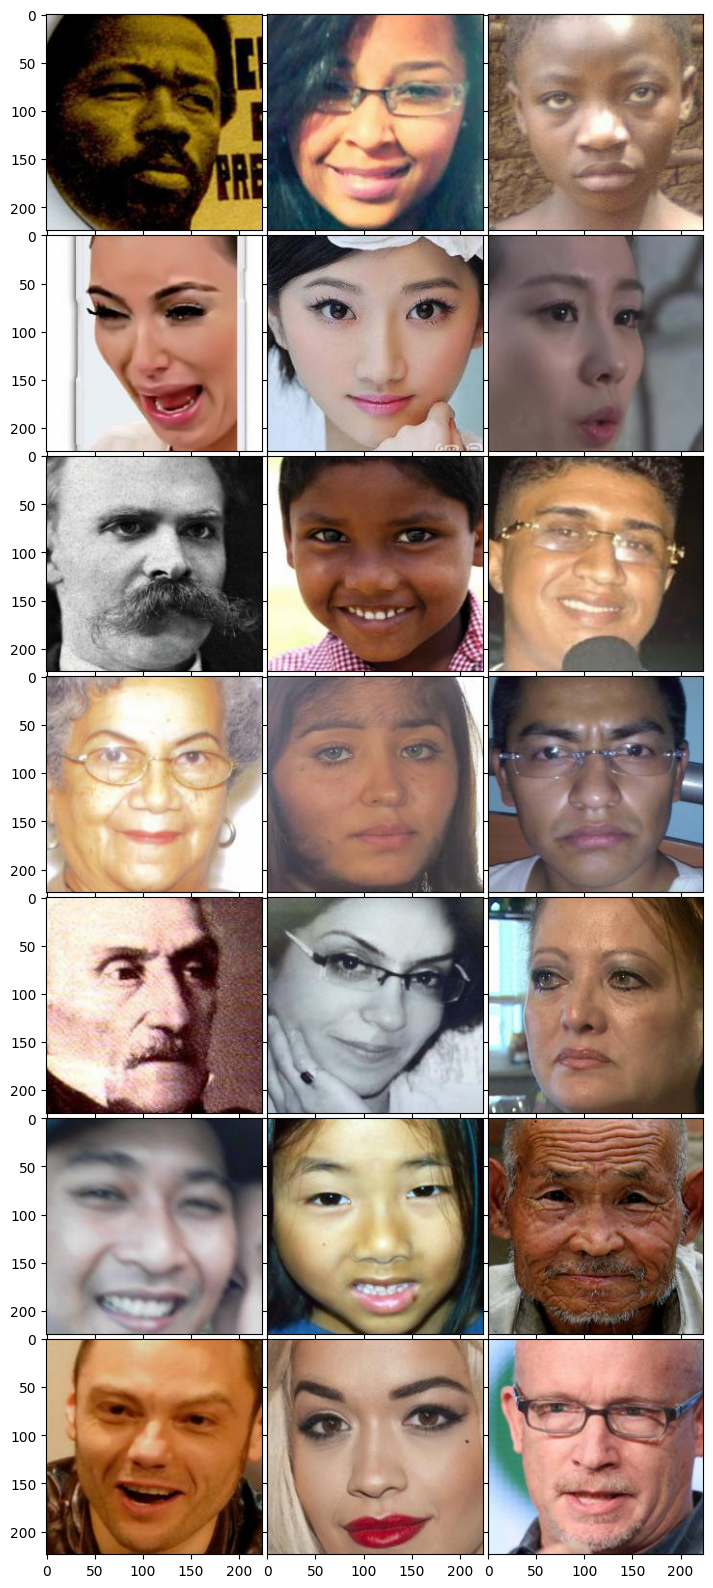